In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import HTML
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,mean_squared_error,log_loss
from sklearn.datasets import make_blobs
from tqdm import tqdm_notebook
import pandas as pd
from sklearn.model_selection import train_test_split as tts
import imageio
import time
import seaborn as sns



In [2]:
my_cmap=matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])

In [3]:
np.random.seed(0)

# Generate Data

In [4]:
data,labels=make_blobs(1200,2,4,random_state=0)
print(data.shape,labels.shape)

(1200, 2) (1200,)


In [5]:
labels

array([2, 2, 3, ..., 0, 2, 1])

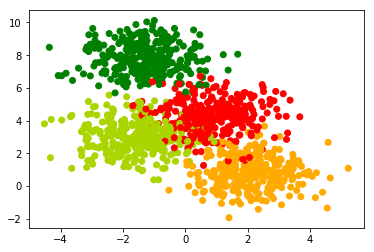

In [6]:
plt.scatter(data[:,0],data[:,1],c=labels,cmap=my_cmap)
plt.show()

In [7]:
labels_orig=labels
labels=np.mod(labels_orig,2)

In [8]:
print(labels)

[0 0 1 ... 0 0 1]


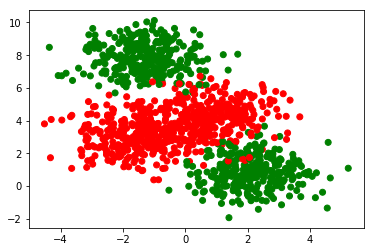

In [9]:
plt.scatter(data[:,0],data[:,1],c=labels,cmap=my_cmap)
plt.show()

# Multiclass Classification

In [10]:
X_train,X_val,Y_train,Y_val=tts(data,labels_orig,stratify=labels_orig,random_state=0)
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(900, 2) (300, 2) (900,) (300,)


In [11]:
# one hot encoding
enc = OneHotEncoder()

In [12]:
Y_train_oh = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
Y_train_oh.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(900, 4)

In [13]:
W1=np.random.randn(2,2)
W2=np.random.randn(2,4)
print(W1,W2)

[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]] [[ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]


# FF class

In [14]:
class FFM:
    
    def __init__(self,W1,W2):
        self.params={}
        self.params["W1"]=W1.copy()
        self.params["W2"]=W2.copy()
        self.params["B1"]=np.zeros((1,2))
        self.params["B2"]=np.zeros((1,4))
        self.num_layers=2
        self.gradients={}
        self.update_params={}
        self.prev_update_params={}
        for i in range(1,self.num_layers+1):
            self.update_params["v_w"+str(i)]=0
            self.update_params["v_b"+str(i)]=0
            self.update_params["m_b"+str(i)]=0
            self.update_params["m_w"+str(i)]=0
            self.prev_update_params["v_w"+str(i)]=0
            self.prev_update_params["v_b"+str(i)]=0
            
    def forward_activation(self,X):
        return 1.0/(1.0 + np.exp(-X))
    
    def grad_activation(self,X):
        return X*(1-X)
    
    def softmax(self,X):
        exps=np.exp(X)
        return exps/np.sum(exps, axis = 1).reshape(-1,1)
    
    def forward_pass(self,X,params=None):
        if params is None:
            params = self.params
        self.A1=np.matmul(X,params["W1"]) + params["B1"] # (n,2) * (2,2) -> (n,2)
        self.H1=self.forward_activation(self.A1) # (n,2)
        self.A2=np.matmul(self.H1,params["W2"]) + params["B2"] # (n,2) * (2,4) -> (n,4)
        self.H2=self.softmax(self.A2) # (n,4)
        return self.H2
    
    def grad(self,X,Y,params=None):
        if params is None:
            params = self.params
        
        self.forward_pass(X,params)
#         m=X.shape[0]
        self.gradients["dA2"]= self.H2 # (N,4)
        self.gradients["dW2"]= np.matmul(self.H1.T,self.gradients["dA2"]) # (2,n) * (n,4) -> (2,4)
        self.gradients["dB2"]= np.sum(self.gradients["dA2"],axis=0).reshape(1,-1) #(n,4) ->(1,4)
        self.gradients["dH1"]= np.matmul(self.gradients["dA2"],self.params["W2"].T)#(n,4)*(4,2)->(n,2)
        self.gradients["dA1"]= np.multiply(self.gradients["dH1"],self.grad_activation(self.H1))#(n,2)
        self.gradients["dW1"]= np.matmul(X.T,self.gradients["dA1"]) #(2,n) * (n,2) -> (2,2)
        self.gradients["dB1"]= np.sum(self.gradients["dA1"],axis=0).reshape(1,-1) #(n,2) ->(1,2)
        
    def predict(self,X):
        Y_pred=self.forward_pass(X)
        return np.array(Y_pred).squeeze()
    
    def fit(self, X, Y, epochs=1, algo= "GD", display_loss=False, 
          eta=1, mini_batch_size=100, eps=1e-8,  
          beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 ):
        
        if display_loss:
            loss = {}
        
        for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
            m = X.shape[0]

            if algo == "GD":
                self.grad(X, Y)
                for i in range(1,self.num_layers+1):
                    self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)

            elif algo == "MiniBatch":
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
                    for i in range(1,self.num_layers+1):
                        self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
                        self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)

            elif algo == "Momentum":
                self.grad(X, Y)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
                    self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
                    self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
                    self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]  

            elif algo == "NAG":
                temp_params = {}
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
                    self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
                    temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
                    temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
                self.grad(X,Y,temp_params)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
                    self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
                    self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
                    self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
                self.prev_update_params=self.update_params 

            elif algo == "AdaGrad":
                self.grad(X, Y)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
                    self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
                    self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)

            elif algo == "RMSProp":
                self.grad(X, Y)
                for i in range(1,self.num_layers+1):
                    self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
                    self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
                    self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)

            elif algo == "Adam":
                self.grad(X, Y)
                num_updates=0
                for i in range(1,self.num_layers+1):
                    num_updates+=1
                    self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
                    self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
                    m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
                    v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
                    self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat

                    self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
                    self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
                    m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
                    v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
                    self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
            if display_loss:
                Y_pred = self.predict(X)
                loss[num_epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)

        if display_loss:
            plt.plot(loss.values(), '-o', markersize=5)
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.show()

In [15]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
        plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
        plt.show()

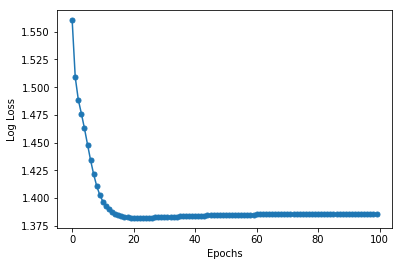

Training accuracy 0.3089
Validation accuracy 0.3167
Wall time: 523 ms


In [16]:
%%time
model = FFM(W1, W2)
model.fit(X_train, Y_train_oh, epochs=100, eta=1, algo="GD", display_loss=True)
print_accuracy()

In [17]:
y_OH_train=Y_train_oh

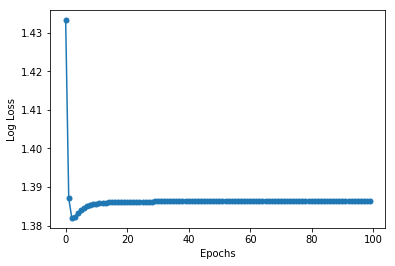

Training accuracy 0.3411
Validation accuracy 0.3467
Wall time: 545 ms


In [18]:
%%time
model = FFM(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=128, display_loss=True)
print_accuracy()

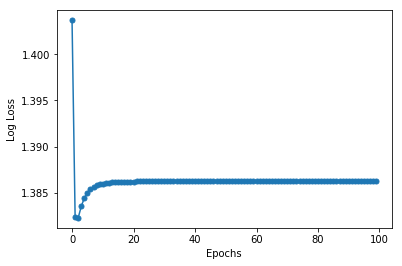

Training accuracy 0.3467
Validation accuracy 0.3567
Wall time: 518 ms


In [19]:
%%time
model = FFM(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=95, display_loss=True)
print_accuracy()

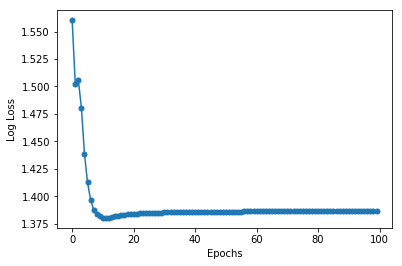

Training accuracy 0.3111
Validation accuracy 0.32
Wall time: 460 ms


In [24]:
%%time
model = FFM(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum",beta=0.9, gamma=0.5, display_loss=True)
print_accuracy()

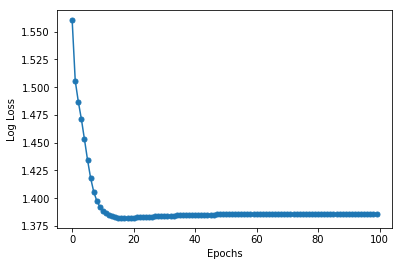

Training accuracy 0.31
Validation accuracy 0.3167
Wall time: 525 ms


In [21]:
%%time
model = FFM(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.5, display_loss=True)
print_accuracy()

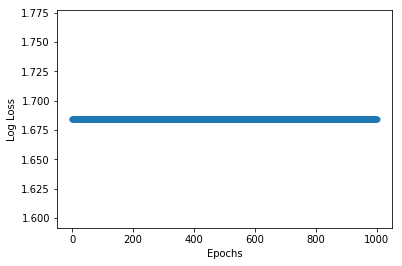

Training accuracy 0.2556
Validation accuracy 0.26
Wall time: 1.58 s


In [29]:
%%time
model = FFM(W1, W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=.9, algo="RMSprop",beta=0.9, display_loss=True)
print_accuracy()

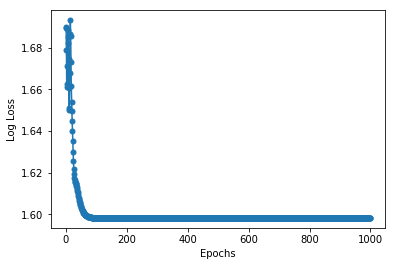

Training accuracy 0.25
Validation accuracy 0.25
Wall time: 2.14 s


In [35]:
%%time
model = FFM(W1, W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=.1, algo="Adam", beta=0.8, display_loss=True)
print_accuracy()

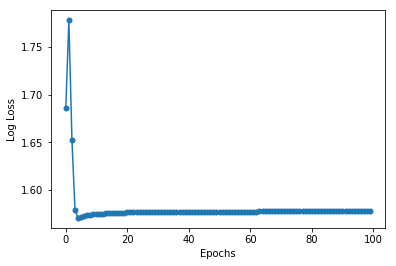

Training accuracy 0.25
Validation accuracy 0.25
Wall time: 466 ms


In [31]:
%%time
model = FFM(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.9, algo="AdaGrad", beta=0.9, display_loss=True)
print_accuracy()